## Objective
Compare all sorters (hdsort, herdingspikes, ironclust, kilosort2, spykingcircus, tridesclous) in spikeinterface paper to prop

## Load Sorters

In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from spikeinterface import NpzSortingExtractor

from src.sorters.prop_signal import PropSignal
from src.sorters.base import SpikeSorter
from src.comparison import Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
SAMP_FREQ = 30  # kHz
SORTERS_ROOT = Path("/data/MEAprojects/spikeinterface/spiketrains/mouse412804_probeC")

MATCH_SCORE = 0.5  # Minimum score needed for a match
TIME_FRAME = (5*60*1000, 10*60*1000)
"""
time_frame:
    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
    If None, use all cooccurrences
"""

'\ntime_frame:\n    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)\n    If None, use all cooccurrences\n'

In [42]:
class Sorter:
    # Wrapper of NpzSortingExtractor for Comparison
    def __init__(self, full_name, name):
        self.npz = NpzSortingExtractor(SORTERS_ROOT / full_name / "sorting_cached.npz")
        self.name = name
        
    def __len__(self):
        return self.npz.get_num_units()
    
    def get_spike_times(self):
        start_ms, end_ms = TIME_FRAME
        
        spike_times = []
        for uid in self.npz.get_unit_ids():
            times = self.npz.get_unit_spike_train(uid) / SAMP_FREQ
            times_ind = start_ms <= times
            times_ind *= times <= end_ms
            if sum(times_ind) > 0:
                spike_times.append(times[times_ind])
        return spike_times

In [44]:
SORTERS_ROOT = Path("/data/MEAprojects/spikeinterface/spiketrains/mouse412804_probeC")

HS = Sorter("herdingspikes", "HS")
KS = Sorter("kilosort2", "KS")
IC = Sorter("ironclust", "IC")
TDC = Sorter("tridesclous", "TDC")
SC = Sorter("spykingcircus", "SC")
HDS = Sorter("hdsort", "HDS")

# PROP = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230728", None)
PROP = SpikeSorter(None, "RT-Sort", np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231022/spike_times.npy", allow_pickle=True))

SORTERS = [PROP, HS, KS, IC, TDC, SC, HDS]
for sorter in SORTERS:
    print(f"{sorter.name}: {len(sorter)} units")

RT-Sort: 108 units
HS: 210 units
KS: 448 units
IC: 234 units
TDC: 187 units
SC: 628 units
HDS: 317 units


100%|██████████| 108/108 [00:01<00:00, 82.96it/s]


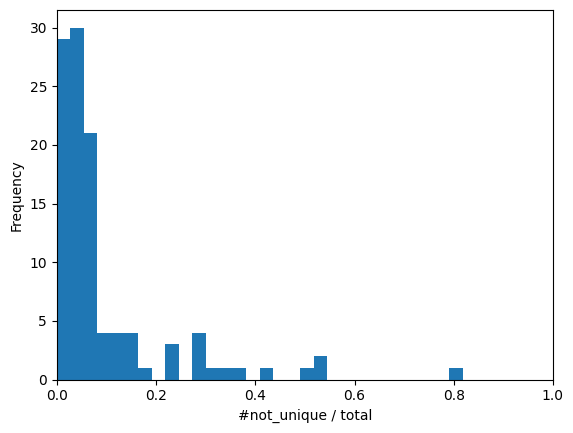

In [45]:
prop_signal = PROP

spike_train_sets = []
spike_trains = prop_signal.get_spike_times()
for train in spike_trains:
    spike_train_sets.append(set(train))

overlap_ratios = []  # ith value = #not_unique/#total for spikes of ith propagation
overlap_matrix = np.zeros((len(prop_signal), len(prop_signal)), dtype=float)  # [i, j] = num overlaps between units i and j / num spikes i
for i in tqdm(range(len(prop_signal))):
    unique = spike_train_sets[i]
    for j in range(len(prop_signal)):
        if i == j:
            continue
        overlap_matrix[i, j] = len(spike_train_sets[i].intersection(spike_train_sets[j])) / len(spike_train_sets[i])
        unique = unique.difference(spike_train_sets[j])
    overlap_ratios.append(
        (len(spike_train_sets[i]) - len(unique)) / (len(spike_train_sets[i]))
    )
    
plt.hist(overlap_ratios, bins=30)
# plt.yticks(range(0, 12, 2))

plt.ylabel("Frequency")
plt.xlabel("#not_unique / total")
plt.xlim(0, 1)
plt.show()
    

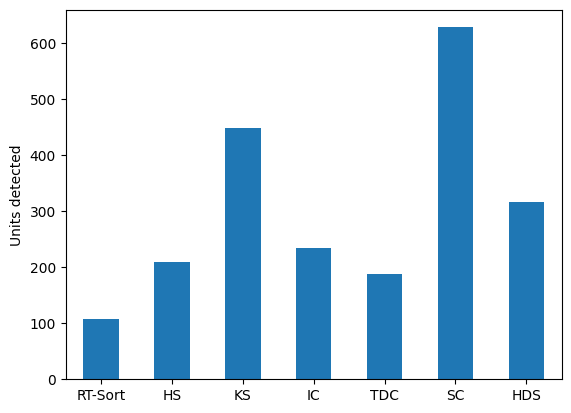

In [46]:
df = DataFrame(data=[len(sorter) for sorter in SORTERS], index=[sorter.name for sorter in SORTERS])
df.plot.bar(rot=0, legend=False)

plt.ylabel("Units detected")
plt.show()

In [47]:
comps_matrix = []
for ref_sorter in tqdm(SORTERS):
    comps = []
    for comp_sorter in SORTERS:
        comp = Comparison(ref_sorter, comp_sorter, score_formula=1, match_score=MATCH_SCORE)
        comps.append(comp)
    comps_matrix.append(comps)
comps_matrix = np.array(comps_matrix, dtype=object)

  0%|          | 0/7 [00:00<?, ?it/s]

/data/MEAprojects/PropSignal/src/comparison.py:334: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  
100%|██████████| 7/7 [14:53<00:00, 127.59s/it]


## Pie Chart Comparison

In [48]:
def plot_pie(sizes, labels):
    # Generate a list of colors for each section using 'YlOrRd' colormap
    # colors = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A']
    # colors = ['#fef2aa', '#fbdc79', '#fbb24a', "#ff8035", "#fa3e22", "#d50e24"]
    colors= ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C']

    # Create the pie chart with white lines separating sections
    wedges, _ = plt.pie(sizes, colors=colors, startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

    # Set the title
    plt.title("Units detected by k sorters")

    # Add labels with the numbers from 'sizes' on the edges of each wedge
    for i, wedge in enumerate(wedges):
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        
        # Numbers outside of wedge
        # x = wedge.r * 1.1 * np.cos(angle * (3.14159 / 180))
        # y = wedge.r * 1.1 * np.sin(angle * (3.14159 / 180))
        # plt.text(x, y, str(sizes[i]), va='center', ha='center')
        
        # Numbers inside of wedge
        x = (wedge.r - 0.15) * np.cos(angle * (np.pi / 180))
        y = (wedge.r - 0.15) * np.sin(angle * (np.pi / 180))
        plt.text(x, y, str(sizes[i]), ha='center', va='center', color='black', fontweight='bold')

    # Add legend
    # plt.legend(wedges, labels, title="k=", loc='best')

    # Display the chart
    plt.show()

### Plot one pie chart each for different score formulas

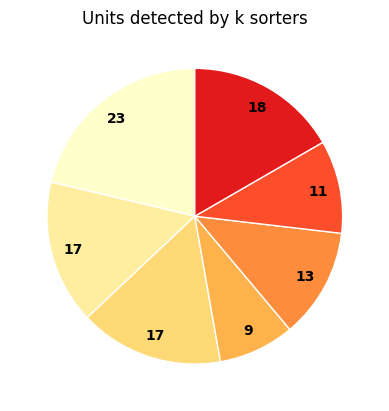

In [54]:
# score = #matches / #spikes_prop
matched_units = []
for comp in comps_matrix[0, :]:
    matched_units.extend(uid for uid in comp.match21 if uid != -1)
_, counts = np.unique(matched_units, return_counts=True)
num_sorters, counts = np.unique(counts, return_counts=True)
plot_pie(counts, num_sorters)

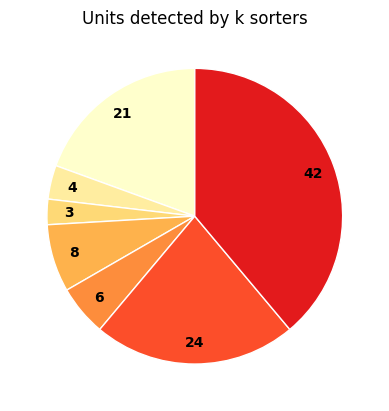

In [51]:
# score = #matches / #spikes_compare_sorter
matched_units = []
for comp in comps_matrix[:, 0]:
    matched_units.extend(uid for uid in comp.match12 if uid != -1)
_, counts = np.unique(matched_units, return_counts=True)
num_sorters, counts = np.unique(counts, return_counts=True)
plot_pie(counts, num_sorters)

In [52]:
# score = #matches / (#spikes_prop + #spikes_compare_sorter - #matches)
matched_units_1_5 = []
for sorter in tqdm(SORTERS[0:]):
    comp = Comparison(PROP, sorter, score_formula=1.5, match_score=MATCH_SCORE)
    matched_units_1_5.extend(uid for uid in comp.match21 if uid != -1)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:08<00:00,  9.85s/it]


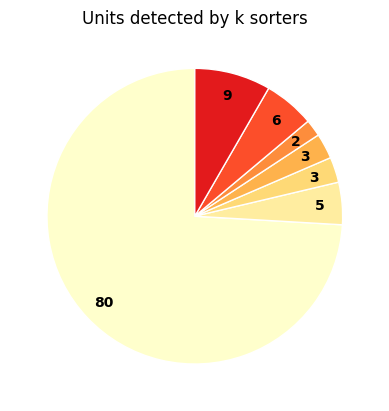

In [53]:
_, counts = np.unique(matched_units_1_5, return_counts=True)
num_sorters, counts = np.unique(counts, return_counts=True)
plot_pie(counts, num_sorters)

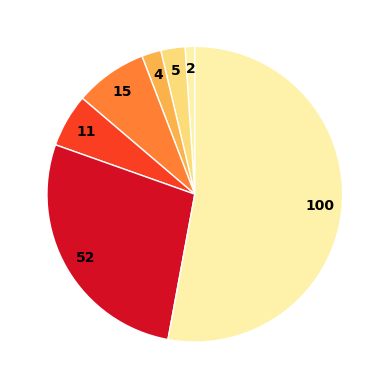

In [11]:
plot_pie([2, 5, 4, 15, 11, 52, 100], [1, 2, 3, 4, 5, 6, 7])

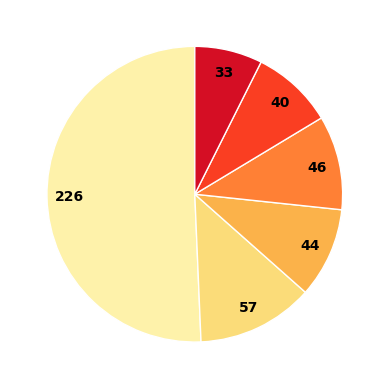

In [12]:
plot_pie([226, 57, 44, 46, 40, 33], [1, 2, 3, 4, 5, 6])

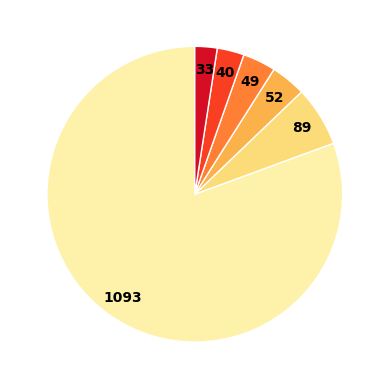

In [13]:
plot_pie([1093, 89, 52, 49, 40, 33], [1, 2, 3, 4, 5, 6])

## Heatmap comparison

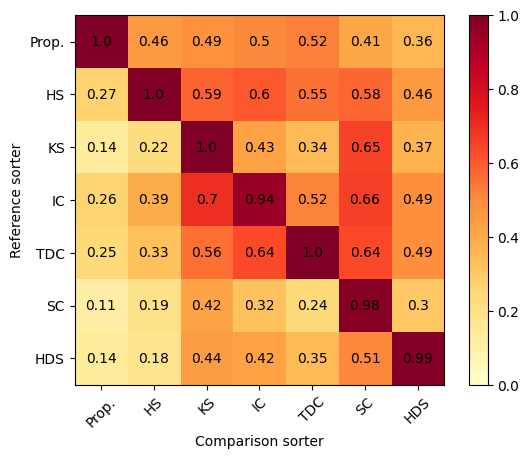

In [34]:
# Num matches divided by num units in reference sorter

scores_heatmap = np.zeros((len(SORTERS), len(SORTERS)), dtype="float32")
for i in range(len(SORTERS)):
    for j in range(len(SORTERS)):
        comp = comps_matrix[i, j]
        num_matches = len([uid for uid in comp.match21 if uid != -1])
        scores_heatmap[i, j] = num_matches / len(SORTERS[i])

sorter_names = [sorter.name for sorter in SORTERS]

# Create the heatmap
heatmap = plt.imshow(scores_heatmap, cmap='YlOrRd', vmin=0, vmax=1)

# Set the tick labels for both axes
plt.xticks(np.arange(len(sorter_names)), sorter_names, rotation=45)
plt.yticks(np.arange(len(sorter_names)), sorter_names)

# Add value annotations to each square
for i in range(scores_heatmap.shape[0]):
    for j in range(scores_heatmap.shape[1]):
        text = plt.text(j, i, round(scores_heatmap[i, j], 2),
                        ha='center', va='center', color='black')

# Label the axes
plt.xlabel("Comparison sorter")
plt.ylabel("Reference sorter")

# Add colorbar
plt.colorbar(heatmap)

# Show the plot
plt.show()


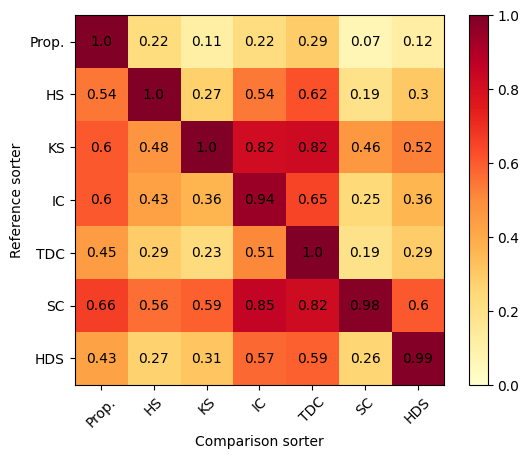

In [35]:
# Num matches divided by num units in comparison sorter

scores_heatmap = np.zeros((len(SORTERS), len(SORTERS)), dtype="float32")
for i in range(len(SORTERS)):
    for j in range(len(SORTERS)):
        comp = comps_matrix[i, j]
        num_matches = len([uid for uid in comp.match21 if uid != -1])
        scores_heatmap[i, j] = num_matches / len(SORTERS[j])

sorter_names = [sorter.name for sorter in SORTERS]

# Create the heatmap
heatmap = plt.imshow(scores_heatmap, cmap='YlOrRd', vmin=0, vmax=1)

# Set the tick labels for both axes
plt.xticks(np.arange(len(sorter_names)), sorter_names, rotation=45)
plt.yticks(np.arange(len(sorter_names)), sorter_names)

# Add value annotations to each square
for i in range(scores_heatmap.shape[0]):
    for j in range(scores_heatmap.shape[1]):
        text = plt.text(j, i, round(scores_heatmap[i, j], 2),
                        ha='center', va='center', color='black')

# Label the axes
plt.xlabel("Comparison sorter")
plt.ylabel("Reference sorter")

# Add colorbar
plt.colorbar(heatmap)

# Show the plot
plt.show()
